# Specifying and Fitting MLPs with Keras

**EE514: Data Analysis and Machine Learning**

[Kevin McGuinness](http://www.eeng.dcu.ie/~mcguinne/), School of Electronic Engineering, Dublin City University

---

[Keras](https://keras.io/) is a popular deep learning library that uses tensorflow or theano under the hood, but makes it a bit easier to specify many types of models.

In this notebook, we illustrate how to use Keras to specify and train a simple multi-layer perceptron model. We test the MLPs capacity to model non-linear boundaries on a dataset of concentric circles and compare this with the Kernel SVM.

## Import packages and define some utility functions

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import seaborn as sns
sns.set_style('white')

In [ ]:
def plot_dataset(X, y):
    figure(figsize=(7,7))
    scatter(X[:, 0], X[:, 1], s=100, c=y, edgecolor='k')
    show()

def plot_decision_function(df, X, y, levels=(0.5,)):
    
    # Find span of data
    x0_min, x1_min = np.min(X, axis=0)
    x0_max, x1_max = np.max(X, axis=0)
    x0_range = x0_max - x0_min
    x1_range = x1_max - x1_min
    
    # Add small buffer around data
    x0_min = x0_min - 0.1 * x0_range
    x0_max = x0_max + 0.1 * x0_range
    x1_min = x1_min - 0.1 * x1_range
    x1_max = x1_max + 0.1 * x1_range
    
    # Generate linearly spaced points
    x0 = np.linspace(x0_min, x0_max, 100)
    x1 = np.linspace(x1_min, x1_max, 100)
    
    # Generate meshgrid
    X0, X1 = np.meshgrid(x0, x1)
    
    # Evaluate decision function for all points on the grid
    Y = df(np.c_[X0.ravel(), X1.ravel()]).reshape(X0.shape)
    
    # Plot the decision function
    figure(figsize=(7,7))
    contour(X0, X1, Y, levels=levels, 
            linestyles=['dashed', 'solid', 'dashed'],
            linewidths=1,
            colors='k')
    
    # Plot the data
    scatter(X[:, 0], X[:, 1], c=y, edgecolor='k')

## Data generation

Create some sample data and show how well the SVM classifier does (very well for this dataset).

In [ ]:
import sklearn
from sklearn.datasets import make_circles

In [ ]:
X, y = make_circles()
plot_dataset(X, y)

## Test the Kernel SVM

Fit an SVM classifier with radial basis function kernel to the data

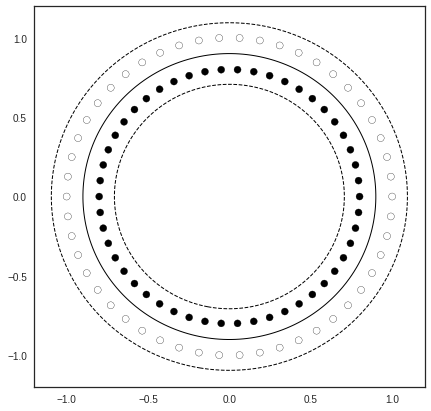

In [ ]:
from sklearn.svm import SVC
clf = SVC()
clf.fit(X, y)
plot_decision_function(clf.decision_function, X, y, levels=(-1, 0, 1))

## Specify the neural network

We will use Keras (https://keras.io/) to specify a simple multi layer perceptron architecture to classify the data. First import what we need from Keras

In [ ]:
import os

from keras.layers import Dense, Input, Activation
from keras.models import Model
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.layers import Dropout

Now specify the architecture. We are going to use a single hidden layer with 30 hidden units and a ReLU activation function. 

We will use the Adam optimizer, which is a fancy version of SGD that converges a bit faster here.

In [ ]:
input = Input(shape=(2,))
hidden = Dense(30, activation='relu', kernel_regularizer=l2(1e-8))(input)
output = Dense(1, activation='sigmoid', kernel_regularizer=l2(1e-8))(hidden)
model = Model(inputs=input, outputs=output)

optimizer = Adam()
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

## Train the model

In [ ]:
# Fit the model. This will be slow the first time it's run because keras needs to compile the computation graph
model.fit(X, y, verbose=2, batch_size=10, epochs=800)

## Plot the decision boundary

The resulting decision function is not as smooth as the SVM, but it separates the data well.

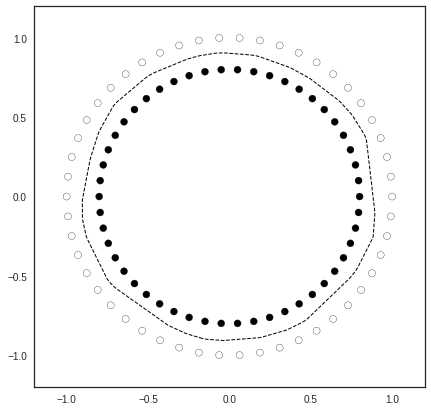

In [ ]:
plot_decision_function(model.predict, X, y, levels=(0.5,))

## Model variation: hinge loss

Lets try a slightly different model. We use the same network structure, but remove the final sigmoid nonlinearity and use a hinge loss instead. This is the same loss as is used by a linear SVM. The hinge loss expects the class labels to be {-1, +1}, so we map to thus range before calling fit.

In [ ]:
input = Input(shape=(2,))
hidden = Dense(30, activation='relu', kernel_regularizer=l2(1e-8))(input)
output = Dense(1, activation='linear', kernel_regularizer=l2(1e-8))(hidden)
model = Model(inputs=input, outputs=output)

optimizer = Adam()
model.compile(optimizer=optimizer, loss='hinge', metrics=['accuracy'])

## Train the model

In [ ]:
model.fit(X, 2*y-1, verbose=2, batch_size=10, epochs=800)

## Plot the decision boundary

This model looks good too. All the data points lie on the margin (dashed line).

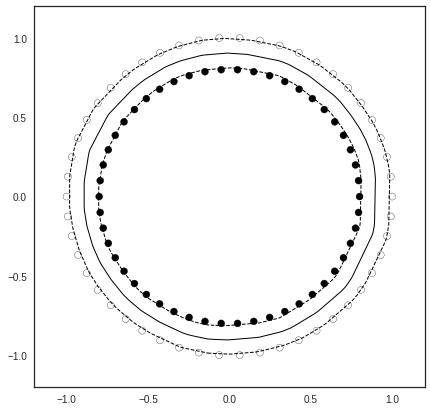

In [ ]:
plot_decision_function(model.predict, X, y, levels=(-1, 0, 1.0))

## Make predictions

The predict function can be used to get predicted labels. > 0 is positive, < 0 is negative.

In [ ]:
model.predict(X)[:10]

array([[ 1.2666678],
       [ 1.1544517],
       [ 1.1714425],
       [-1.0988929],
       [-1.0334103],
       [-1.1645906],
       [-1.1523197],
       [-1.0974088],
       [ 1.1409106],
       [ 1.2716823]], dtype=float32)

## Compare the MLP with the SVM

In [ ]:
# we can use model.summary() to get information on layers and parameter counts
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 30)                90        
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 31        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


How does this compare with the SVM classifier? Let's look at the total number of parameters.

In [ ]:
n_support_vectors = clf.support_vectors_.shape[0]
dim_support_vectors = clf.support_vectors_.shape[1]
n_alpha = n_support_vectors
total_params = n_support_vectors * dim_support_vectors + n_alpha + 1 # bias
total_params

301

There are only 100 data points of 2 dimensions, so the SVM actually memorizes the training data. The MLP actually uses fewer parameters to approximate the decision function than the SVM.